# A Reinforcement Learning Based Network Scheduler For Deadline-Driven Data Transfers

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
import math
import itertools
import operator
import helpFunctions as help
import helpFunctionsRL as helpRL

## Initializing Variables

In [2]:
N = 3
B = 10
alpha = 0.85
beta = 1
p_exp_zero = 0.999
episodes = 10**4
Sum_Rmin_list = [4,8,12,16,20]

## Equal Paritioning

In [3]:
sr_srmin_ep = []
for Sum_Rmin in Sum_Rmin_list:
    sr = []
    for epi in range(0,episodes):
        queue = help.generate_queue(Sum_Rmin,N)
        queue = help.equal_rate_scheduler(queue,N,B)
        sr.append(sum(queue[:,3])/N)
    sr_ep = sum(sr)/episodes
    sr_srmin_ep.append(sr_ep)

## Random Scheduling

In [4]:
sr_srmin_rand = []
for Sum_Rmin in Sum_Rmin_list:
    sr = []
    for epi in range(0,episodes):
        queue = help.generate_queue(Sum_Rmin,N)
        queue = help.random_rate_scheduler(queue,N,B)
        sr.append(sum(queue[:,3])/N)     
    sr_random = sum(sr)/episodes
    sr_srmin_rand.append(sr_random)

## Earliest Deadline First

In [5]:
sr_srmin_edf = []
for Sum_Rmin in Sum_Rmin_list:
    sr = []
    for epi in range(0,episodes):
        queue = help.generate_queue(Sum_Rmin,N)
        queue = help.edf_rate_scheduler(queue,N,B)
        sr.append(sum(queue[:,3])/N)
    sr_edf = sum(sr)/episodes
    sr_srmin_edf.append(sr_edf)

## RL Method

In [ ]:
from operator import index


sr_rl_min = []

for m in Sum_Rmin_list:

    sr = []

    flow = [i for i in range(0,episodes)]
    p_exp = [0 for i in range(0,episodes)]
    p_exp[0] = p_exp_zero

    #firstSetStates = list(allStates(m,N))
    
    allPossibleStates = helpRL.everyState(N,m)
    allPossibleActions = helpRL.everyAction(B,N)
    qTable = np.zeros([len(allPossibleStates),len(allPossibleActions)])


    for i in range(0,episodes):
        
        #print("Sum Rmin Value: ",m," Episode Number: ",i)
        actions = list(allStates(B,N))

        queue = help.basics(m,N)

        
        currentState = queue[:,0]
        check = checkIfAllNegative(currentState)
        time = 0
        p_exp[i] = max(p_exp[i-1]**i,0.01)


        while check:

            check3 = np.count_nonzero(qTable)/(np.shape(qTable)[0]*np.shape(qTable)[1])
            
            if check3<=1-p_exp[i]:
                currentActionIndex = random.randint(0,len(actions)-1)
            else:
                print(p_exp[i])
                indexCurrentState = allPossibleStates.index(tuple(currentState))
                maxValue = max(qTable[indexCurrentState][:])
                currentACtionIndex = np.where(qTable==maxValue)[1][0]
                print(currentACtionIndex)

            rewardAction = np.array(actions[currentActionIndex])
            nextState = np.array(currentState) - rewardAction


            check2 = checkIfOneNegative(nextState)
            if check2[0]:
                    
                listCurrentState = list(nextState)
                enum = enumerate(listCurrentState)
                for j in list(reversed(check2[1])):
                    del listCurrentState[j]
                    if queue[j,1]<time:
                        queue[j,3]=1

                nextState = tuple(listCurrentState)

                currentState = nextState

                check = checkIfAllNegative(nextState)
                if check:
                    update = reward(nextState, rewardAction)
                    xCoord = allPossibleStates.index(tuple(nextState))
                    qTable[xCoord, currentActionIndex] = qTable[xCoord, currentActionIndex]+ beta*update
                
                M = N - len(check2[1])
                if M==0:
                    break
                actions = list(allStates(B,M))

            currentState = nextState
            
            
            check = checkIfAllNegative(currentState)

            time = time+1
        
        sr.append(sum(queue[:,3])/N)
    sr_rl = sum(sr)/episodes
    sr_rl_min.append(sr_rl)


## Plot

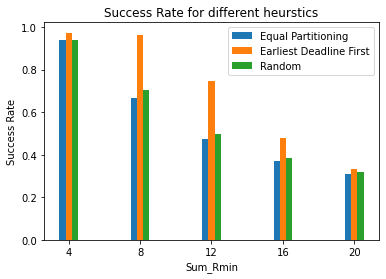

In [6]:
width=0.35

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(np.array(Sum_Rmin_list), sr_srmin_ep,width)
rects2 = ax.bar(np.array(Sum_Rmin_list)+width, sr_srmin_edf, width)
rects3 = ax.bar(np.array(Sum_Rmin_list)+2*width, sr_srmin_rand, width)
#rects4 = ax.bar(np.array(Sum_Rmin_list)+3*width, sr_rl_min, width)

# add some
ax.set_ylabel('Success Rate')
ax.set_title('Success Rate for different heurstics')
ax.set_xlabel('Sum_Rmin')
ax.set_xticks(np.array(Sum_Rmin_list)+width)
ax.set_xticklabels( ('4', '8', '12', '16', '20') )

ax.legend( (rects1[0], rects2[0],rects3[0]), ('Equal Partitioning', 'Earliest Deadline First','Random') )
#ax.legend( (rects1[0], rects2[0],rects3[0],rects4[0]), ('Equal Partitioning', 'Earliest Deadline First','Random','RL Agent') )

plt.show()